In [2]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import seaborn as sns
#import rpy2.rinterface_lib.callbacks
import logging
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import  LogisticRegression
from keras.models import load_model
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from functools import partial
from sklearn.ensemble import StackingClassifier
from bayes_opt import BayesianOptimization
#from rpy2.robjects import pandas2ri
from joblib import dump, load
import pickle
#import anndata2ri
import anndata
from joblib import Parallel, delayed
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import scanpy as sc
import pandas as pd

import anndata
import scipy as sp
from scipy.stats import spearmanr
from skopt import gp_minimize
from skopt.space import Real
import importlib
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")
import pickle as pkl
import subprocess
import sys
from sklearnex import patch_sklearn 
patch_sklearn()
from tensorflow.keras import regularizers
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import skimage
def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
adata_concat = sc.read_h5ad('GSE144434_processed.h5ad')

In [26]:
#load the model
best_linear_svm = load('best_linear_svm.joblib')
best_linear_svm_features=pd.read_excel('Used_features.xlsx')['LINEAR  SVM'].dropna().values.tolist()
best_rbf_svm = load('best_rbf_svm.joblib')
best_rbf_svm_features=pd.read_excel('Used_features.xlsx')['RBF SVM'].dropna().values.tolist()
best_lr = load('best_lr.joblib')
best_lr_features=pd.read_excel('Used_features.xlsx')['LR'].dropna().values.tolist()
best_mlp_linear = load_model('best_mlp_linear.h5')
best_stack = load('best_stack.joblib')
best_stack_features=pd.read_excel('Used_features.xlsx')['Stack'].dropna().values.tolist()
best_mlp_rbf = load_model('best_mlp_rbf.h5')

In [7]:
sc.pp.filter_genes(adata_concat, min_cells = 10)

In [8]:
genedf = pd.DataFrame(adata_concat.X.A, index = adata_concat.obs_names, columns = adata_concat.var_names)

In [9]:
X = genedf
y = adata_concat.obs['batch'].astype(int)==1
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
adata_train = adata_concat[X_train.index,:]
adata_val = adata_concat[X_val.index,:]

In [10]:
terms = pd.read_excel('DE_table.xlsx',index_col = 0)

In [12]:
corr_w_HNRNPLL = dict()
for i in X_train.columns:
    corr_val = spearmanr(X_train['HNRNPLL'], X_train[i])
    corr_w_HNRNPLL[i] = corr_val
corr_w_HNRNPLL_df = pd.DataFrame.from_dict(corr_w_HNRNPLL, orient='index').rename(columns={0: 'statistic', 1: 'pvalue'})

In [14]:
train_result_table = pd.DataFrame(np.zeros([6,3]))
train_result_table.index = ['SVM linear','SVM rbf','LR','stack','MLP linear SVM features','MLP rbf SVM features']
train_result_table.columns = ['Accuracy (%)','Precision (%)','Recall (%)']
test_result_table = train_result_table.copy()

In [15]:
test_prediction_table = pd.DataFrame(np.zeros([X_val.shape[0],6]))
test_prediction_table.columns = ['SVM linear','SVM rbf','LR','stack','MLP linear SVM features','MLP rbf SVM features']
train_prediction_table =pd.DataFrame(np.zeros([X_train.shape[0],6]))
train_prediction_table.columns = ['SVM linear','SVM rbf','LR','stack','MLP linear SVM features','MLP rbf SVM features']

In [16]:
X_CV = X_train
y_CV = y_train
folds = 10
global folds
global X_CV
global y_CV
global corr_w_HNRNPLL_df
global terms

In [17]:
log2foldmask = (terms['normalized_effect'].astype('double') >= 1) | \
                   (terms['normalized_effect'].astype('double') <= -1)
pvalmask = terms['q_value'].astype('double') < 0.05
DEs = terms['gene_short_name'][log2foldmask & pvalmask]
CORRs = corr_w_HNRNPLL_df.loc[corr_w_HNRNPLL_df['pvalue'] < 0.05].sort_values(by='statistic', ascending=False).index[:int(np.floor(corr_w_HNRNPLL_df.shape[0]*0.005))]
global DEs
global CORRs

## Data Loading

In [8]:
adata_concat = sc.read_h5ad('GSE144434_processed.h5ad')

In [9]:
sc.pp.filter_genes(adata_concat, min_cells = 10)

In [136]:
adata_unseen = sc.read_h5ad('GSE150132_processed.h5ad')

In [138]:
cd45raneg_df = pd.DataFrame(adata_unseen.X.A, index = adata_unseen.obs_names, columns = adata_unseen.var_names)

## Data splitting

In [10]:
genedf = pd.DataFrame(adata_concat.X.A, index = adata_concat.obs_names, columns = adata_concat.var_names)

In [11]:
X = genedf
y = adata_concat.obs['batch'].astype(int)==1
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
adata_train = adata_concat[X_train.index,:]
adata_val = adata_concat[X_val.index,:]

## Find DE

In [71]:
colnames = X_train.index
rownames = X_train.columns
condition = adata_concat[X_train.index,:].obs['batch']
counts = adata_concat[X_train.index,:].layers['counts'].T

In [73]:
%%R -i counts -i colnames -i rownames -i condition
colnames(counts) = colnames
rownames(counts) = rownames

srat <- CreateSeuratObject(counts = counts, project = "transwell", min.cells = 0, min.features = 0, assay = "RNA")

srat[["condition"]] = condition

In [74]:
%%R
library(monocle3)
library(SeuratWrappers)
cds <- as.cell_data_set(srat)
cds <- estimate_size_factors(cds)
cds@rowRanges@elementMetadata@listData[["gene_short_name"]] <- rownames(srat[["RNA"]])
#cds = preprocess_cds(cds, num_dim = 50)

In [75]:
%%R
gene_fits <- fit_models(cds, model_formula_str = "~condition")

In [76]:
%%R
fit_coefs <- coefficient_table(gene_fits)

In [83]:
%%R -o terms
library(magrittr) # needs to be run every time you start R and want to use %>%
library(dplyr)    # alternatively, this also loads %>%

terms <- fit_coefs %>% filter(term == "condition-1")
#colnames(terms)
terms = terms %>% select(gene_short_name, term, q_value, normalized_effect)

In [84]:
terms['-logQ'] = -np.log10(terms['q_value'])
terms = terms[terms['-logQ']>0]

In [ ]:
terms.to_excel('DE_table.xlsx')

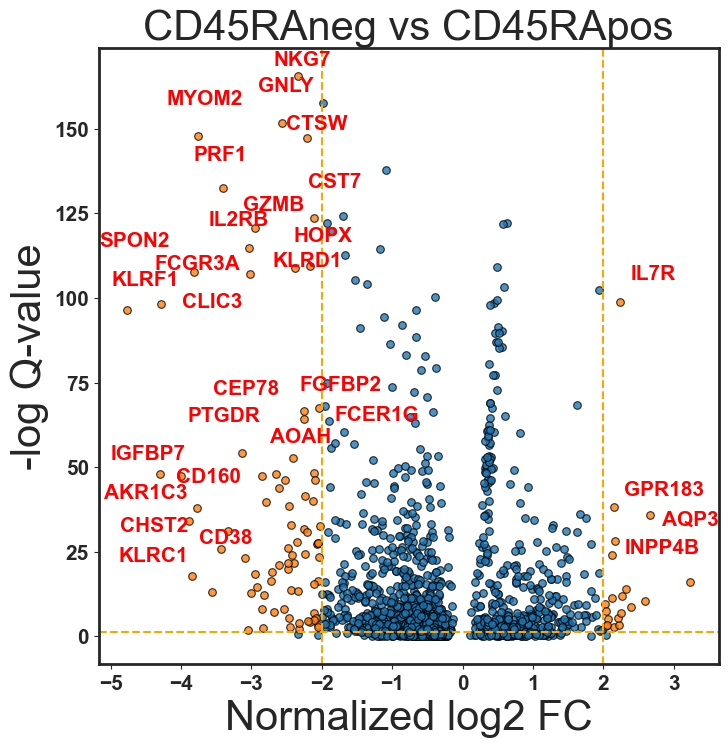

In [427]:
##### Volcano plot of results
from adjustText import adjust_text
plt.rcParams.update({'font.size': 14, 'font.weight': 'bold','axes.linewidth':2})
lowqval_de = terms[np.array(terms['-logQ']>=-np.log10(0.05)) & np.array(abs(terms['normalized_effect'])>=2)]
other_de = terms[np.array(terms['-logQ']<-np.log10(0.05)) | np.array(abs(terms['normalized_effect'])<2)]

fig, ax = plt.subplots()
sb.regplot(other_de['normalized_effect'], other_de['-logQ'], fit_reg=False, scatter_kws={'s':30, 'edgecolors': 'black', 'linewidths': 0.8})
sb.regplot(lowqval_de['normalized_effect'], lowqval_de['-logQ'], fit_reg=False, scatter_kws={'s':30,'edgecolors': 'black', 'linewidths': 0.8})
ax.set_xlabel("Normalized log2 FC", fontsize=30)
ax.set_ylabel("-log Q-value", fontsize=30)
ax.tick_params(labelsize=15)
ax.set_title('CD45RAneg vs CD45RApos',size = 30)
    
    
    
# Label names and positions
x = [i*1.1-0.1 for i in lowqval_de['normalized_effect']]
y = [i*1.05 for i in lowqval_de['-logQ']]
labels = lowqval_de['gene_short_name']

# Show only some labels to avoid overcrowding the figure
to_remove = np.where(np.array(lowqval_de['gene_short_name'].str.startswith('RP'))|np.array(lowqval_de['gene_short_name'].str.startswith('MT'))
                     |(np.array(lowqval_de['normalized_effect']>1)&np.array(lowqval_de['normalized_effect']<2)&np.array(lowqval_de['-logQ']<50))
                     |np.array(lowqval_de['-logQ']<25)|(np.array(lowqval_de['normalized_effect']<-1)&np.array(lowqval_de['normalized_effect']>-3)&np.array(lowqval_de['-logQ']<50)))
labels = ["" if i in to_remove[0] else lab for i,lab in enumerate(labels) ]
texts = []
for i,txt in enumerate(labels):
    texts.append(ax.text(x[i], y[i], txt,size = 15, color= 'red', weight = 'bold'))

adjust_text(texts)
#ax.xaxis.label.set_fontweight('bold')
#ax.yaxis.label.set_fontweight('bold')
#ax.yaxis.label.set_fontsize(22)
    #ax.annotate(txt, (x[i], y[i]),size = 10,bbox=dict(boxstyle="Square,pad=0.3", fc="orange", ec="b", lw=2, alpha = 0.6))
    #plt.xlim([-0.6,0.65])
plt.axhline(y=-np.log10(0.05), color="orange", linestyle="--")
plt.axvline(x = -2, color="orange", linestyle="--")
plt.axvline(x = 2, color="orange", linestyle="--")
plt.savefig('CD45RAnegtoposvolcano.png',bbox_inches='tight')

### Linear

In [ ]:
def train_svm_single_fold(X_CV, y_CV, DE_thresh_up, DE_thresh_down, biog_thresh, svm_C):
    patch_sklearn()
    _X_train, _X_val, _y_train, _y_val = train_test_split(X_CV, y_CV, test_size=0.2)
    # Feature selection 1
    log2foldmask = (terms['normalized_effect'].astype('double') >= DE_thresh_up) | \
                   (terms['normalized_effect'].astype('double') <= DE_thresh_down)
    pvalmask = terms['q_value'].astype('double') < 0.05
    DEs = terms['gene_short_name'][log2foldmask & pvalmask]
    # Feature selection 2
    CORRs = corr_w_HNRNPLL_df.loc[corr_w_HNRNPLL_df['pvalue'] < 0.05].sort_values(by='statistic', ascending=False).index[:int(np.floor(corr_w_HNRNPLL_df.shape[0]*biog_thresh))]
    features = np.union1d(DEs, CORRs)
    _X_CV = _X_train[features]
    svm_clf = make_pipeline(StandardScaler(), LinearSVC(C=svm_C, dual=False, max_iter=1000, random_state=42))
    svm_clf.fit(_X_CV,_y_train)
    _y_pred = svm_clf.predict(_X_val[features])
    accuracy = accuracy_score(_y_val, _y_pred)
    return accuracy

def modi_svm_cv(result):
    DE_thresh_up = result[0]
    DE_thresh_down = result[1]
    biog_thresh = result[2]
    svm_C = result[3]
    accuracys = Parallel(n_jobs=-1)(delayed(train_svm_single_fold)(X_CV, y_CV, DE_thresh_up, DE_thresh_down, biog_thresh, svm_C) for _ in range(folds))
    accuracy_cv = np.mean(accuracys)
    error = 1 - accuracy_cv
    return error

param_space = [
    Real(1, 4, name='DE_thresh_up'),
    Real(-4, -1, name='DE_thresh_down'),
    Real(1e-6, 0.1, name='biog_thresh'),
    Real(1e-6, 1, name='svm_C')
]

In [ ]:
result_linear = gp_minimize(modi_svm_cv, dimensions=param_space, n_calls=50, random_state=42, n_jobs=-1)

In [ ]:
log2foldmask = (terms['normalized_effect'].astype('double') >= result_linear.x[0]) | \
                   (terms['normalized_effect'].astype('double') <= result_linear.x[1])
pvalmask = terms['q_value'].astype('double') < 0.05
DEs = terms['gene_short_name'][log2foldmask & pvalmask]
CORRs = corr_w_HNRNPLL_df.loc[corr_w_HNRNPLL_df['pvalue'] < 0.05].sort_values(by='statistic', ascending=False).index[:int(np.floor(corr_w_HNRNPLL_df.shape[0]*result_linear.x[2]))]
best_linear_svm_features = np.union1d(DEs, CORRs)

In [ ]:
best_linear_svm = make_pipeline(StandardScaler(), LinearSVC(C=result_linear.x[3], dual=False, max_iter=1000, random_state=42))

In [ ]:
best_linear_svm.fit(X_train[best_linear_svm_features], y_train)

In [27]:
y_pred_val_linear = best_linear_svm.predict(X_val[best_linear_svm_features])
test_result_table.loc['SVM linear', 'Accuracy (%)'] = np.round(accuracy_score(y_val, y_pred_val_linear)*100,3)
test_result_table.loc['SVM linear', 'Precision (%)'] = np.round(precision_score(y_val, y_pred_val_linear)*100,3)
test_result_table.loc['SVM linear', 'Recall (%)'] = np.round(recall_score(y_val, y_pred_val_linear)*100,3)

In [28]:
y_pred_train_linear = best_linear_svm.predict(X_train[best_linear_svm_features])
train_result_table.loc['SVM linear', 'Accuracy (%)'] = np.round(accuracy_score(y_train, y_pred_train_linear)*100,3)
train_result_table.loc['SVM linear', 'Precision (%)'] = np.round(precision_score(y_train, y_pred_train_linear)*100,3)
train_result_table.loc['SVM linear', 'Recall (%)'] = np.round(recall_score(y_train, y_pred_train_linear)*100,3)

In [29]:
test_prediction_table['SVM linear'] = y_pred_val_linear
train_prediction_table['SVM linear'] = y_pred_train_linear

In [ ]:
#save the model and features
dump(best_linear_svm, 'best_linear_svm.joblib')
pd.DataFrame(best_linear_svm_features).to_excel('best_linear_svm_features.xlsx')

In [30]:
train_result_table

,Accuracy (%),Precision (%),Recall (%)
SVM linear,92.891,92.381,87.651
SVM rbf,0.000,0.000,0.000
LR,0.000,0.000,0.000
stack,0.000,0.000,0.000
MLP linear SVM features,0.000,0.000,0.000
MLP rbf SVM features,0.000,0.000,0.000


In [31]:
test_result_table

,Accuracy (%),Precision (%),Recall (%)
SVM linear,86.589,88.559,76.277
SVM rbf,0.000,0.000,0.000
LR,0.000,0.000,0.000
stack,0.000,0.000,0.000
MLP linear SVM features,0.000,0.000,0.000
MLP rbf SVM features,0.000,0.000,0.000


In [317]:
#format unseen
unseen_df = pd.DataFrame()
for i in best_linear_svm_features:
    if i in cd45raneg_df.columns:
        unseen_df[i] = cd45raneg_df[i]
    else:
        unseen_df[i] = np.zeros(cd45raneg_df.shape[0])

In [318]:
#predict the unseen
y_pred_unseen = best_linear_svm.predict(unseen_df)
accuracy = accuracy_score(np.zeros([cd45raneg_df.shape[0],1]), y_pred_unseen)

print("Accuracy:", accuracy)

Accuracy: 0.9959971980386271


In [319]:
adata_unseen.obs['linear_svm'] = y_pred_unseen
adata_unseen.obs['linear_svm']=adata_unseen.obs['linear_svm'].astype('str')

### RBF

In [ ]:
def train_svm_single_fold(X_CV, y_CV, DE_thresh_up, DE_thresh_down, biog_thresh, svm_C, svm_gamma):
    patch_sklearn()
    _X_train, _X_val, _y_train, _y_val = train_test_split(X_CV, y_CV, test_size=0.3)
    # Feature selection 1
    log2foldmask = (terms['normalized_effect'].astype('double') >= DE_thresh_up) | \
                   (terms['normalized_effect'].astype('double') <= DE_thresh_down)
    pvalmask = terms['q_value'].astype('double') < 0.05
    DEs = terms['gene_short_name'][log2foldmask & pvalmask]
    # Feature selection 2
    CORRs = corr_w_HNRNPLL_df.loc[corr_w_HNRNPLL_df['pvalue'] < 0.05].sort_values(by='statistic', ascending=False).index[:int(np.floor(corr_w_HNRNPLL_df.shape[0]*biog_thresh))]
    features = np.union1d(DEs, CORRs)
    _X_CV = _X_train[features]
    svm_clf = SVC(C=svm_C, gamma=svm_gamma, kernel='rbf', probability=True, random_state=42)
    svm_clf.fit(_X_CV,_y_train)
    _y_pred = svm_clf.predict(_X_val[features])
    accuracy = accuracy_score(_y_val, _y_pred)
    return accuracy

def modi_svm_cv(result):
    DE_thresh_up = result[0]
    DE_thresh_down = result[1]
    biog_thresh = result[2]
    svm_C = result[3]
    svm_gamma = result[4]
    accuracys = Parallel(n_jobs=-1)(delayed(train_svm_single_fold)(X_CV, y_CV, DE_thresh_up, DE_thresh_down, biog_thresh, svm_C,svm_gamma) for _ in range(folds))
    accuracy_cv = np.mean(accuracys)
    error = 1 - accuracy_cv
    return error

param_space = [
    Real(1.5, 4, name='DE_thresh_up'),
    Real(-4, -1.5, name='DE_thresh_down'),
    Real(1e-6, 0.05, name='biog_thresh'),
    Real(1e-6, 1, name='svm_C'),
    Real(1e-6, 2, name='svm_gamma')
]

In [ ]:
result_rbf = gp_minimize(modi_svm_cv, dimensions=param_space, n_calls=100, random_state=42, n_jobs=-1)

In [ ]:
best_rbf_svm_features = np.union1d(DEs, CORRs)

In [ ]:
log2foldmask = (terms['normalized_effect'].astype('double') >= result_rbf.x[0]) | \
                   (terms['normalized_effect'].astype('double') <= result_rbf.x[1])
pvalmask = terms['q_value'].astype('double') < 0.05
DEs = terms['gene_short_name'][log2foldmask & pvalmask]
CORRs = corr_w_HNRNPLL_df.loc[corr_w_HNRNPLL_df['pvalue'] < 0.05].sort_values(by='statistic', ascending=False).index[:int(np.floor(corr_w_HNRNPLL_df.shape[0]*result_rbf.x[2]))]
best_rbf_svm_features = np.union1d(DEs, CORRs)

In [ ]:
len(best_rbf_svm_features)

In [ ]:
best_rbf_svm = SVC(C=result_rbf.x[3], gamma=result_rbf.x[4], kernel='rbf', max_iter=1000, random_state=42)

In [ ]:
best_rbf_svm.fit(X_train[best_rbf_svm_features], y_train)

In [32]:
y_pred_val_rbf = best_rbf_svm.predict(X_val[best_rbf_svm_features])
test_result_table.loc['SVM rbf', 'Accuracy (%)'] = np.round(accuracy_score(y_val, y_pred_val_rbf)*100,3)
test_result_table.loc['SVM rbf', 'Precision (%)'] = np.round(precision_score(y_val, y_pred_val_rbf)*100,3)
test_result_table.loc['SVM rbf', 'Recall (%)'] = np.round(recall_score(y_val, y_pred_val_rbf)*100,3)

In [33]:
y_pred_train_rbf = best_rbf_svm.predict(X_train[best_rbf_svm_features])
train_result_table.loc['SVM rbf', 'Accuracy (%)'] = np.round(accuracy_score(y_train, y_pred_train_rbf)*100,3)
train_result_table.loc['SVM rbf', 'Precision (%)'] = np.round(precision_score(y_train, y_pred_train_rbf)*100,3)
train_result_table.loc['SVM rbf', 'Recall (%)'] = np.round(recall_score(y_train, y_pred_train_rbf)*100,3)

In [34]:
test_prediction_table['SVM rbf'] = y_pred_val_rbf
train_prediction_table['SVM rbf'] = y_pred_train_rbf

In [ ]:
#save the model and features
dump(best_rbf_svm, 'best_rbf_svm.joblib')
pd.DataFrame(best_rbf_svm_features).to_excel('best_rbf_svm_features.xlsx')

In [35]:
train_result_table

,Accuracy (%),Precision (%),Recall (%)
SVM linear,92.891,92.381,87.651
SVM rbf,99.453,99.596,98.896
LR,0.000,0.000,0.000
stack,0.000,0.000,0.000
MLP linear SVM features,0.000,0.000,0.000
MLP rbf SVM features,0.000,0.000,0.000


In [36]:
test_result_table

,Accuracy (%),Precision (%),Recall (%)
SVM linear,86.589,88.559,76.277
SVM rbf,89.942,90.196,83.942
LR,0.000,0.000,0.000
stack,0.000,0.000,0.000
MLP linear SVM features,0.000,0.000,0.000
MLP rbf SVM features,0.000,0.000,0.000


In [322]:
#format unseen
unseen_df = pd.DataFrame()
for i in best_rbf_svm_features:
    if i in cd45raneg_df.columns:
        unseen_df[i] = cd45raneg_df[i]
    else:
        unseen_df[i] = np.zeros(cd45raneg_df.shape[0])

In [323]:
#predict the unseen
y_pred_unseen = best_rbf_svm.predict(unseen_df)
accuracy = accuracy_score(np.zeros([cd45raneg_df.shape[0],1]), y_pred_unseen)

print("Accuracy:", accuracy)

Accuracy: 0.9996497548283798


In [324]:
adata_unseen.obs['rbf_svm'] = y_pred_unseen
adata_unseen.obs['rbf_svm']=adata_unseen.obs['rbf_svm'].astype('str')

### LR

In [ ]:
def train_lr_single_fold(X_CV, y_CV, DE_thresh_up, DE_thresh_down, biog_thresh, log_reg_C):
    patch_sklearn()
    _X_train, _X_val, _y_train, _y_val = train_test_split(X_CV, y_CV, test_size=0.2)
    # Feature selection 1
    log2foldmask = (terms['normalized_effect'].astype('double') >= DE_thresh_up) | \
                   (terms['normalized_effect'].astype('double') <= DE_thresh_down)
    pvalmask = terms['q_value'].astype('double') < 0.05
    DEs = terms['gene_short_name'][log2foldmask & pvalmask]
    # Feature selection 2
    CORRs = corr_w_HNRNPLL_df.loc[corr_w_HNRNPLL_df['pvalue'] < 0.05].sort_values(by='statistic', ascending=False).index[:int(np.floor(corr_w_HNRNPLL_df.shape[0]*biog_thresh))]
    features = np.union1d(DEs, CORRs)
    _X_CV = _X_train[features]
    lr_clf = LogisticRegression(solver='saga', C=log_reg_C, penalty='l2', random_state=42)
    lr_clf.fit(_X_CV,_y_train)
    _y_pred = lr_clf.predict(_X_val[features])
    accuracy = accuracy_score(_y_val, _y_pred)
    return accuracy

def modi_lr_cv(result):
    DE_thresh_up = result[0]
    DE_thresh_down = result[1]
    biog_thresh = result[2]
    log_reg_C = result[3]
    accuracys = Parallel(n_jobs=-1)(delayed(train_lr_single_fold)(X_CV, y_CV, DE_thresh_up, DE_thresh_down, biog_thresh, log_reg_C) for _ in range(folds))
    accuracy_cv = np.mean(accuracys)
    error = 1 - accuracy_cv
    return error

param_space = [
    Real(1, 4, name='DE_thresh_up'),
    Real(-4, -1, name='DE_thresh_down'),
    Real(1e-6, 0.1, name='biog_thresh'),
    Real(1e-6, 1, name='log_reg_C'),
]

In [ ]:
result_lr = gp_minimize(modi_lr_cv, dimensions=param_space, n_calls=50, random_state=42, n_jobs=-1)

In [ ]:
log2foldmask = (terms['normalized_effect'].astype('double') >= result_lr.x[0]) | \
                   (terms['normalized_effect'].astype('double') <= result_lr.x[1])
pvalmask = terms['q_value'].astype('double') < 0.05
DEs = terms['gene_short_name'][log2foldmask & pvalmask]
CORRs = corr_w_HNRNPLL_df.loc[corr_w_HNRNPLL_df['pvalue'] < 0.05].sort_values(by='statistic', ascending=False).index[:int(np.floor(corr_w_HNRNPLL_df.shape[0]*result_lr.x[2]))]
best_lr_features = np.union1d(DEs, CORRs)

In [ ]:
best_lr = LogisticRegression(solver='saga', C=result_lr.x[3], penalty='l2', random_state=42)
best_lr.fit(X_train[best_lr_features], y_train)

In [38]:
y_pred_val_lr = best_lr.predict(X_val[best_lr_features])
test_result_table.loc['LR', 'Accuracy (%)'] = np.round(accuracy_score(y_val, y_pred_val_lr)*100,3)
test_result_table.loc['LR', 'Precision (%)'] = np.round(precision_score(y_val, y_pred_val_lr)*100,3)
test_result_table.loc['LR', 'Recall (%)'] = np.round(recall_score(y_val, y_pred_val_lr)*100,3)

In [39]:
y_pred_train_lr = best_lr.predict(X_train[best_lr_features])
train_result_table.loc['LR', 'Accuracy (%)'] = np.round(accuracy_score(y_train, y_pred_train_lr)*100,3)
train_result_table.loc['LR', 'Precision (%)'] = np.round(precision_score(y_train, y_pred_train_lr)*100,3)
train_result_table.loc['LR', 'Recall (%)'] = np.round(recall_score(y_train, y_pred_train_lr)*100,3)

In [40]:
test_prediction_table['LR'] = y_pred_val_lr
train_prediction_table['LR'] = y_pred_train_lr

In [ ]:
#save the model and features
dump(best_lr, 'best_lr.joblib')
pd.DataFrame(best_lr_features).to_excel('best_lr_features.xlsx')

In [41]:
train_result_table

,Accuracy (%),Precision (%),Recall (%)
SVM linear,92.891,92.381,87.651
SVM rbf,99.453,99.596,98.896
LR,99.307,99.393,98.695
stack,0.000,0.000,0.000
MLP linear SVM features,0.000,0.000,0.000
MLP rbf SVM features,0.000,0.000,0.000


In [42]:
test_result_table

,Accuracy (%),Precision (%),Recall (%)
SVM linear,86.589,88.559,76.277
SVM rbf,89.942,90.196,83.942
LR,88.776,88.327,82.847
stack,0.000,0.000,0.000
MLP linear SVM features,0.000,0.000,0.000
MLP rbf SVM features,0.000,0.000,0.000


In [327]:
#format unseen
unseen_df = pd.DataFrame()
for i in best_LR_features:
    if i in cd45raneg_df.columns:
        unseen_df[i] = cd45raneg_df[i]
    else:
        unseen_df[i] = np.zeros(cd45raneg_df.shape[0])

In [328]:
#predict the unseen
y_pred_unseen = best_LR.predict(unseen_df)
accuracy = accuracy_score(np.zeros([cd45raneg_df.shape[0],1]), y_pred_unseen)

print("Accuracy:", accuracy)

Accuracy: 0.8862203542479736


In [329]:
adata_unseen.obs['LR'] = y_pred_unseen
adata_unseen.obs['LR']=adata_unseen.obs['LR'].astype('str')

### MLP linear

In [ ]:
best_linear_svm_features=pd.read_excel('model/Used_features.xlsx',index_col = 0).iloc[:,0].dropna().values.tolist()

In [ ]:
# define the neural network architecture
def build_model(learning_rate, dropout_rate, num_hidden_layers, num_neurons):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(num_neurons, input_shape=(len(best_linear_svm_features),), activation='relu'))
    for i in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons, activation='relu'))
        model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
X_CV = X_train
y_CV = y_train
folds = 5
global folds

def modi_mlp_cv(result):
    learning_rate = result[0]
    dropout_rate =result[1]
    num_hidden_layers=result[2]
    num_neurons=result[3]

    loss = []
    for i in range(0,folds):
        _X_train, _X_val, _y_train, _y_val = train_test_split(X_CV, y_CV, test_size=0.2)

        _X_CV = _X_train[best_linear_svm_features]

        model = build_model(learning_rate, dropout_rate, num_hidden_layers, num_neurons)
        history = model.fit(_X_CV, _y_train, epochs=10, batch_size=32, verbose=0)

        val_loss, val_acc = model.evaluate(_X_val[best_linear_svm_features], _y_val, verbose=0)
        loss.append(val_loss)
        print(val_loss)

    avg_loss = np.mean(loss)
    return avg_loss

param_space = [
    Real(0.0001, 0.01, name='learning_rate'),
    Real(0.1, 0.5, name='dropout_rate'),
    Integer(1, 3, name='num_hidden_layers'),
    Integer(16, 128, name='num_neurons'),
]

result_mlp_linear = gp_minimize(modi_mlp_cv, dimensions=param_space, n_calls=50, random_state=42,n_jobs=-1)

In [ ]:
best_mlp_linear = build_model(*result_mlp_linear.x)
best_mlp_linear.fit(X_train[best_linear_svm_features], y_train, epochs=10, batch_size=32, verbose=0)

In [48]:
y_pred_val_mlp_linear = best_mlp_linear.predict(X_val[best_linear_svm_features])
test_result_table.loc['MLP linear SVM features', 'Accuracy (%)'] = np.round(accuracy_score(y_val, y_pred_val_mlp_linear>0.5)*100,3)
test_result_table.loc['MLP linear SVM features', 'Precision (%)'] = np.round(precision_score(y_val, y_pred_val_mlp_linear>0.5)*100,3)
test_result_table.loc['MLP linear SVM features', 'Recall (%)'] = np.round(recall_score(y_val, y_pred_val_mlp_linear>0.5)*100,3)

22/22 [==============================] - 0s 902us/step


In [49]:
y_pred_train_mlp_linear = best_mlp_linear.predict(X_train[best_linear_svm_features])
train_result_table.loc['MLP linear SVM features', 'Accuracy (%)'] = np.round(accuracy_score(y_train, y_pred_train_mlp_linear>0.5)*100,3)
train_result_table.loc['MLP linear SVM features', 'Precision (%)'] = np.round(precision_score(y_train, y_pred_train_mlp_linear>0.5)*100,3)
train_result_table.loc['MLP linear SVM features', 'Recall (%)'] = np.round(recall_score(y_train, y_pred_train_mlp_linear>0.5)*100,3)

86/86 [==============================] - 0s 883us/step


In [50]:
test_prediction_table['MLP linear SVM features'] = y_pred_val_mlp_linear>0.5
train_prediction_table['MLP linear SVM features'] = y_pred_train_mlp_linear>0.5

In [51]:
train_result_table

,Accuracy (%),Precision (%),Recall (%)
SVM linear,92.891,92.381,87.651
SVM rbf,99.453,99.596,98.896
LR,99.307,99.393,98.695
stack,0.000,0.000,0.000
MLP linear SVM features,92.526,94.892,83.936
MLP rbf SVM features,95.479,92.913,94.779


In [52]:
test_result_table

,Accuracy (%),Precision (%),Recall (%)
SVM linear,86.589,88.559,76.277
SVM rbf,89.942,90.196,83.942
LR,88.776,88.327,82.847
stack,0.000,0.000,0.000
MLP linear SVM features,87.901,93.213,75.182
MLP rbf SVM features,89.213,88.760,83.577


In [ ]:
#save the model
best_mlp_linear.save('best_mlp_linear.h5')

In [ ]:
best_linear_svm_features=pd.DataFrame(best_linear_svm_features).to_excel('best_linear_svm_features.xlsx')

In [ ]:
with open('result_mlp_linear.pkl', 'wb') as file:
    pickle.dump(result_mlp_linear, file)

In [337]:
#format unseen
unseen_df = pd.DataFrame()
for i in best_linear_svm_features:
    if i in cd45raneg_df.columns:
        unseen_df[i] = cd45raneg_df[i]
    else:
        unseen_df[i] = np.zeros(cd45raneg_df.shape[0])

In [338]:
#predict the unseen
y_pred_unseen = best_mlp.predict(unseen_df)
accuracy = accuracy_score(np.zeros([cd45raneg_df.shape[0],1]), y_pred_unseen>0.5)

print("Accuracy:", accuracy)

625/625 [==============================] - 3s 5ms/step
Accuracy: 0.9974482137496248


In [345]:
adata_unseen.obs['mlp'] = y_pred_unseen>0.5
adata_unseen.obs['mlp']=adata_unseen.obs['mlp'].astype('str')

### MLP rbf

In [ ]:
# define the neural network architecture
def build_model(learning_rate, dropout_rate, num_hidden_layers, num_neurons,epochs,batch_size):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(num_neurons, input_shape=(len(best_rbf_svm_features),), activation='relu'))
    for i in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons, activation='relu',kernel_regularizer=regularizers.l1(0.01)))
        model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
X_CV = X_train
y_CV = y_train
folds = 5
global folds

def modi_mlp_cv(result):
    learning_rate = result[0]
    dropout_rate =result[1]
    num_hidden_layers=result[2]
    num_neurons=result[3]
    epochs = result[4]
    batch_size = result[5]

    loss = []
    f1_scores = []
    for i in range(0,folds):
        _X_train, _X_val, _y_train, _y_val = train_test_split(X_CV, y_CV, test_size=0.2)

        _X_CV = _X_train[best_rbf_svm_features]

        model = build_model(learning_rate, dropout_rate, num_hidden_layers, num_neurons,epochs,batch_size)
        history = model.fit(_X_CV, _y_train, epochs=epochs, batch_size=batch_size, verbose=0)

        #val_loss, val_acc = model.evaluate(_X_val[best_rbf_svm_features], _y_val, verbose=0)
        #loss.append(val_loss)
        #print(val_loss)
        
        y_pred = model.predict(_X_val[best_rbf_svm_features])
        y_pred_binary = np.round(y_pred).astype(int)
        f1 = f1_score(_y_val, y_pred_binary, average='weighted')
        f1_scores.append(f1)

    #avg_loss = np.mean(loss)
    avg_f1 = np.mean(f1_scores)
    avg_diff = 1 - avg_f1
    return avg_diff

param_space = [
    Real(0.0001, 0.01, name='learning_rate'),
    Real(0.1, 0.5, name='dropout_rate'),
    Integer(1, 3, name='num_hidden_layers'),
    Integer(16, 128, name='num_neurons'),
    Integer(100, 1000, name='epochs'),
    Integer(16, 128, name='batch_size')
]

result_mlp_rbf = gp_minimize(modi_mlp_cv, dimensions=param_space, n_calls=10, random_state=42,n_jobs=-1)

In [ ]:
best_mlp_rbf = build_model(*result_mlp_rbf.x)
best_mlp_rbf.fit(X_train[best_rbf_svm_features], y_train, epochs=result_mlp_rbf.x[4], batch_size=result_mlp_rbf.x[5], verbose=0)

In [43]:
y_pred_val_mlp_rbf = best_mlp_rbf.predict(X_val[best_rbf_svm_features])
test_result_table.loc['MLP rbf SVM features', 'Accuracy (%)'] = np.round(accuracy_score(y_val, y_pred_val_mlp_rbf>0.5)*100,3)
test_result_table.loc['MLP rbf SVM features', 'Precision (%)'] = np.round(precision_score(y_val, y_pred_val_mlp_rbf>0.5)*100,3)
test_result_table.loc['MLP rbf SVM features', 'Recall (%)'] = np.round(recall_score(y_val, y_pred_val_mlp_rbf>0.5)*100,3)

22/22 [==============================] - 0s 1ms/step


In [44]:
y_pred_train_mlp_rbf = best_mlp_rbf.predict(X_train[best_rbf_svm_features])
train_result_table.loc['MLP rbf SVM features', 'Accuracy (%)'] = np.round(accuracy_score(y_train, y_pred_train_mlp_rbf>0.5)*100,3)
train_result_table.loc['MLP rbf SVM features', 'Precision (%)'] = np.round(precision_score(y_train, y_pred_train_mlp_rbf>0.5)*100,3)
train_result_table.loc['MLP rbf SVM features', 'Recall (%)'] = np.round(recall_score(y_train, y_pred_train_mlp_rbf>0.5)*100,3)

86/86 [==============================] - 0s 985us/step


In [45]:
test_prediction_table['MLP rbf SVM features'] = y_pred_val_mlp_rbf>0.5
train_prediction_table['MLP rbf SVM features'] = y_pred_train_mlp_rbf>0.5

In [46]:
train_result_table

,Accuracy (%),Precision (%),Recall (%)
SVM linear,92.891,92.381,87.651
SVM rbf,99.453,99.596,98.896
LR,99.307,99.393,98.695
stack,0.000,0.000,0.000
MLP linear SVM features,0.000,0.000,0.000
MLP rbf SVM features,95.479,92.913,94.779


In [47]:
test_result_table

,Accuracy (%),Precision (%),Recall (%)
SVM linear,86.589,88.559,76.277
SVM rbf,89.942,90.196,83.942
LR,88.776,88.327,82.847
stack,0.000,0.000,0.000
MLP linear SVM features,0.000,0.000,0.000
MLP rbf SVM features,89.213,88.760,83.577


In [ ]:
#save the model
best_mlp_rbf.save('best_mlp_rbf.h5')

In [ ]:
with open('result_mlp_rbf.pkl', 'wb') as file:
    pickle.dump(result_mlp_rbf, file)

In [337]:
#format unseen
unseen_df = pd.DataFrame()
for i in best_linear_svm_features:
    if i in cd45raneg_df.columns:
        unseen_df[i] = cd45raneg_df[i]
    else:
        unseen_df[i] = np.zeros(cd45raneg_df.shape[0])

In [338]:
#predict the unseen
y_pred_unseen = best_mlp.predict(unseen_df)
accuracy = accuracy_score(np.zeros([cd45raneg_df.shape[0],1]), y_pred_unseen>0.5)

print("Accuracy:", accuracy)

625/625 [==============================] - 3s 5ms/step
Accuracy: 0.9974482137496248


In [345]:
adata_unseen.obs['mlp_rbf'] = y_pred_unseen>0.5
adata_unseen.obs['mlp_rbf']=adata_unseen.obs['mlp_rbf'].astype('str')

### Stacked

In [ ]:
def modi_stack_cv(result):
    DE_thresh_up = result[0]
    DE_thresh_down =result[1]
    biog_thresh=result[2]
    svm_C=result[3]
    log_reg_C=result[4]

    accuracy = []
    for i in range(0,folds):
        _X_train, _X_val, _y_train, _y_val = train_test_split(X_CV, y_CV, test_size=0.2)

        log2foldmask = (terms['normalized_effect'].astype('double') >= DE_thresh_up) | \
                   (terms['normalized_effect'].astype('double') <= DE_thresh_down)
        pvalmask = terms['q_value'].astype('double') < 0.05
        DEs = terms['gene_short_name'][log2foldmask & pvalmask]
        # Feature selection 2
        CORRs = corr_w_HNRNPLL_df.loc[corr_w_HNRNPLL_df['pvalue'] < 0.05].sort_values(by='statistic', ascending=False).index[:int(np.floor(corr_w_HNRNPLL_df.shape[0]*biog_thresh))]
        features = np.union1d(DEs, CORRs)
        _X_CV = _X_train[features]

        log_reg = LogisticRegression(solver='saga', C=log_reg_C, penalty='l2', random_state=42)
        svm_clf = SVC(C=svm_C,  kernel='linear', probability=True, random_state=42)

        base_classifiers = [
        ('logistic_regression', log_reg),
        ('svm_clf', svm_clf)]
        meta_classifier = LogisticRegression(solver='lbfgs', random_state=42)
        stacking_clf = StackingClassifier(estimators=base_classifiers, final_estimator=meta_classifier)

        stacking_clf.fit(_X_CV, _y_train)

        _y_pred = stacking_clf.predict(_X_val[features])

        accuracy.append(accuracy_score(_y_val, _y_pred))
    accuracy_cv = np.mean(accuracy)
    error = 1-accuracy_cv
    print(accuracy_cv)
    return error

param_space = [
    Real(1, 4, name='DE_thresh_up'),
    Real(-4, -1, name='DE_thresh_down'),
    Real(1e-6, 0.1, name='biog_thresh'),
        Real(1e-6, 100, name='svm_C'),
    Real(1e-6, 2, name='log_reg_C')
]

result_stack = gp_minimize(modi_stack_cv, dimensions=param_space, n_calls=30, random_state=42,n_jobs=-1)

In [ ]:
svm_clf_stack = SVC(C=result_stack.x[3],  kernel='linear', probability=True, random_state=42)
log_reg_stack = LogisticRegression(solver='saga', C=result_stack.x[4], penalty='l2', random_state=42)

base_classifiers_stack = [
    ('logistic_regression', log_reg_stack),
    ('svm', svm_clf_stack)]

meta_classifier_stack = LogisticRegression(solver='lbfgs', random_state=42)
best_stack = StackingClassifier(estimators=base_classifiers_stack, final_estimator=meta_classifier_stack)

log2foldmask = (terms['normalized_effect'].astype('double') >= result_stack.x[0]) | \
                   (terms['normalized_effect'].astype('double') <= result_stack.x[1])
pvalmask = terms['q_value'].astype('double') < 0.05
DEs = terms['gene_short_name'][log2foldmask & pvalmask]
CORRs = corr_w_HNRNPLL_df.loc[corr_w_HNRNPLL_df['pvalue'] < 0.05].sort_values(by='statistic', ascending=False).index[:int(np.floor(corr_w_HNRNPLL_df.shape[0]*result_stack.x[2]))]
best_stack_features = np.union1d(DEs, CORRs)

best_stack.fit(X_train[best_stack_features], y_train)

In [56]:
y_pred_val_stack = best_stack.predict(X_val[best_stack_features])
test_result_table.loc['stack', 'Accuracy (%)'] = np.round(accuracy_score(y_val, y_pred_val_stack)*100,3)
test_result_table.loc['stack', 'Precision (%)'] = np.round(precision_score(y_val, y_pred_val_stack)*100,3)
test_result_table.loc['stack', 'Recall (%)'] = np.round(recall_score(y_val, y_pred_val_stack)*100,3)

In [57]:
y_pred_train_stack = best_stack.predict(X_train[best_stack_features])
train_result_table.loc['stack', 'Accuracy (%)'] = np.round(accuracy_score(y_train, y_pred_train_stack)*100,3)
train_result_table.loc['stack', 'Precision (%)'] = np.round(precision_score(y_train, y_pred_train_stack)*100,3)
train_result_table.loc['stack', 'Recall (%)'] = np.round(recall_score(y_train, y_pred_train_stack)*100,3)

In [58]:
test_prediction_table['stack'] = y_pred_val_stack
train_prediction_table['stack'] = y_pred_train_stack

In [61]:
#save the model and features
dump(best_stack, 'best_stack.joblib')
pd.DataFrame(best_stack_features).to_excel('best_stack_features.xlsx')

In [59]:
train_result_table

,Accuracy (%),Precision (%),Recall (%)
SVM linear,92.891,92.381,87.651
SVM rbf,99.453,99.596,98.896
LR,99.307,99.393,98.695
stack,96.172,97.043,92.269
MLP linear SVM features,92.526,94.892,83.936
MLP rbf SVM features,95.479,92.913,94.779


In [60]:
test_result_table

,Accuracy (%),Precision (%),Recall (%)
SVM linear,86.589,88.559,76.277
SVM rbf,89.942,90.196,83.942
LR,88.776,88.327,82.847
stack,88.776,90.871,79.927
MLP linear SVM features,87.901,93.213,75.182
MLP rbf SVM features,89.213,88.760,83.577


In [332]:
#format unseen
unseen_df = pd.DataFrame()
for i in best_stack_features:
    if i in cd45raneg_df.columns:
        unseen_df[i] = cd45raneg_df[i]
    else:
        unseen_df[i] = np.zeros(cd45raneg_df.shape[0])

In [333]:
#predict the unseen
y_pred_unseen = best_stack.predict(unseen_df)
accuracy = accuracy_score(np.zeros([cd45raneg_df.shape[0],1]), y_pred_unseen)

print("Accuracy:", accuracy)

Accuracy: 0.9403582507755429


In [334]:
adata_unseen.obs['stack'] = y_pred_unseen
adata_unseen.obs['stack']=adata_unseen.obs['stack'].astype('str')